In [ ]:
!pip install google-cloud-storage
!pip install pandas

In [1]:
import numpy as np
import pandas as pd

### read the file

In [2]:
df_merge_quality = pd.read_csv('US_patent_abstract_5000_2015_with_title_1_5y.csv')
df_merge_quality.shape

(5000, 30)

In [3]:
max(df_merge_quality['quality_index_4'])

0.8642147026094559

In [4]:
min(df_merge_quality['quality_index_4'])

0.0238514872446279

In [5]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

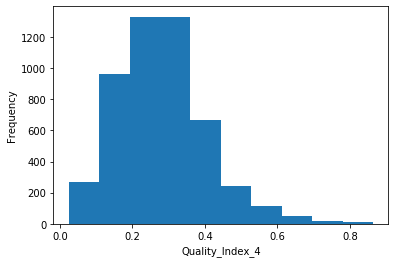

In [6]:
plt.hist(df_merge_quality['quality_index_4'], density=False)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Quality_Index_4');

In [7]:
df_merge_quality

,Unnamed: 0,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match,appln_id,pub_nbr,filing,...,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank,text
0,701919,US-9210117-B2,An invitation information push method includes...,20130208,Invitation information push method and system,What is claimed is: \n \n 1. An invi...,US09210117,407142987,US09210117,2013,...,2,0,0.520408,0.914825,0.402597,2.0,0.229088,0.251782,0,Invitation information push method and system....
1,356119,US-8715323-B2,A connector is provided for linear implants su...,20111017,Coronal angulating connector,What is claimed is: \n \n 1. An impl...,US08715323,405679017,US08715323,2011,...,15,0,0.000000,0.226843,0.130435,3.0,0.118815,0.198961,0,Coronal angulating connector. A connector is p...
2,832228,US-9414578-B2,"A device for spearfishing, which device may in...",20131119,Spearfishing apparatus,What is claimed is: \n \n 1. A spear...,US09414578,440484304,US09414578,2013,...,7,0,0.753968,0.739062,0.087500,3.0,0.353373,0.411789,1,Spearfishing apparatus. A device for spearfish...
3,170137,US-7987148-B2,Disclosed are embodiments of systems and metho...,20100520,Systems and methods for prioritizing media fil...,1. A computer-implemented method for the autom...,US07987148,328063700,US07987148,2010,...,122,0,0.713885,0.958138,0.566996,5.0,0.482869,0.629272,1,Systems and methods for prioritizing media fil...
4,156457,US-8519743-B2,A semiconductor integrated circuit comprises a...,20100312,Semiconductor integrated circuit,What is claimed is: \n \n 1. A semic...,US08519743,331361461,US08519743,2010,...,3,0,0.320000,0.534979,0.296296,7.0,0.250661,0.252287,0,Semiconductor integrated circuit. A semiconduc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,374073,US-8713032-B2,"Methods, systems and articles of manufacture f...",20111202,Cross-platform cloud-based map creation,What is claimed is: \n \n 1. A compu...,US08713032,365873243,US08713032,2011,...,4,0,0.686914,0.931641,0.656250,3.0,0.457711,0.428220,1,Cross-platform cloud-based map creation. Metho...
4996,609358,US-8835927-B2,A display substrate includes a gate line exten...,20121114,Display substrate,What is claimed is: \n \n 1. A displ...,US08835927,410675886,US08835927,2012,...,6,0,0.659722,0.666667,1.000000,2.0,0.359248,0.361225,1,Display substrate. A display substrate include...
4997,618209,US-9181277-B2,The present invention relates to the field of ...,20121114,Aminoquinazoline derivatives and their salts a...,What is claimed is: \n \n 1. A compo...,US09181277,420889733,US09181277,2012,...,26,0,0.472659,0.911124,0.198413,3.0,0.300691,0.325389,1,Aminoquinazoline derivatives and their salts a...
4998,242142,US-9221342-B2,A method for displaying graphical objects. The...,20110331,Method and device for displaying information i...,The invention claimed is: \n \n 1. A...,US09221342,381597066,US09221342,2011,...,4,0,0.655223,0.934055,0.850340,4.0,0.476494,0.403608,1,Method and device for displaying information i...


### create a model

In [8]:
import pickle as cPickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os
import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

Using TensorFlow backend.


In [9]:
MAX_SENT_LENGTH = 30
MAX_SENTS = 30
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [10]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [11]:
data_train = df_merge_quality

In [12]:
print(data_train.shape)

(5000, 30)


In [13]:
data_train['quality_rank'].value_counts()

0    2992
1    2008
Name: quality_rank, dtype: int64

In [14]:
2992/5000

0.5984

In [62]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/nobu_yamaguchi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
from nltk import tokenize

claims = []
labels = []
texts = []

for idx in range(data_train.claims_text.shape[0]):

    text = clean_str(str(data_train.iloc[idx]['claims_text']))
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    claims.append(sentences)
    labels.append(data_train.iloc[idx]['quality_rank'])

In [16]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

In [17]:
data.shape

(5000, 30, 30)

In [18]:
for i, sentences in enumerate(claims):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
            #for word in wordTokens:
                if word in tokenizer.word_index.keys():
                    if (k < MAX_SENT_LENGTH) and (tokenizer.word_index[word] < MAX_NB_WORDS):
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1

In [19]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 31084 unique tokens.


In [20]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (5000, 30, 30)
Shape of label tensor: (5000, 2)


In [18]:
data[0]

array([[   13,     2,    26,    21,   102,     4,   548,   250,   241,
            1,    26,     7,     2,    10,    26,     5,     2,   132,
            4,  1277,     1,   250,     4,   216,     2,    10,   196,
            5,     2,    12],
       [   20,     1,    26,     3,     8,    13,   241,     1,   132,
           61,   117,     1,    10,   542,    30,     7,    37,     4,
          998,    59,    27,     1,    10,   542,    30,     2,    10,
          172,     3,   542],
       [   29,     1,    26,     3,     8,    13,   241,     1,   132,
           61,   116,     1,   568,    46,     7,    37,     4,   998,
           59,    27,     1,    12,   542,    30,     2,    12,   172,
            3,   542,    28],
       [   32,     1,    26,     3,     8,    29,   241,     1,    46,
         1547,     4,     1, 12492,    12,   196,    59,    27,     1,
          616,    12,   172,     3,   542,    71,    14,  1636,     4,
            1,    75,    26],
       [   41,     1,    26,

In [21]:
#data = data[indices]
#labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [22]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [23]:
print('Number of positive and negative reviews in traing and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in traing and validation set
[2397. 1603.]
[595. 405.]


In [24]:
# Standard python helper libraries.
import os, sys, re, json, time
import itertools, collections
from importlib import reload
from IPython.display import display

# NumPy and SciPy for matrix ops

import scipy.sparse


# Helper libraries
#from w266_common import utils, vocabulary, tf_embed_viz
#import glove_helper; reload(glove_helper)

#hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available

### use GloVe for embedding

In [25]:
GLOVE_DIR = "data/glove"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [26]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [55]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=False)

In [56]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)), name='W')
        self.b = K.variable(self.init((self.attention_dim, )), name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)), name='u')
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
 
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b)) #

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)


        #if mask is not None:
        #    # Cast the mask to floatX to avoid float64 upcasting in theano
        #    print('mask')
        #    ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        ait = K.expand_dims(ait)
 
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [57]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(GRU(100, return_sequences=True))(embedded_sequences)
l_att = AttLayer(100)(l_lstm)
sentEncoder = Model(sentence_input, l_att)

tracking <tf.Variable 'att_layer_7/W:0' shape=(200, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_7/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_7/u:0' shape=(100, 1) dtype=float32> u


In [58]:
claims_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
claims_encoder = TimeDistributed(sentEncoder)(claims_input)
l_lstm_sent = Bidirectional(GRU(30, return_sequences=True))(claims_encoder)

In [59]:
l_lstm_sent.shape

TensorShape([None, 30, 60])

In [60]:
#l_att_sent = AttLayer(100)(l_lstm_sent)
l_att_sent = AttLayer(100)(l_lstm_sent)

tracking <tf.Variable 'att_layer_8/W:0' shape=(60, 100) dtype=float32> W
tracking <tf.Variable 'att_layer_8/b:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'att_layer_8/u:0' shape=(100, 1) dtype=float32> u


In [61]:
l_att_dense = Dense(100, activation='relu')(l_att_sent)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_dense = Dense(100, activation='relu')(l_att_dense)
l_att_sent_drop = Dropout(rate=0.2)(l_att_dense)
preds = Dense(2, activation='sigmoid')(l_att_sent_drop)
model = Model(claims_input, preds)

In [62]:
preds.shape

TensorShape([None, 2])

In [63]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [64]:
print("model fitting - Hierachical attention network 0.2")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=8, batch_size=50)

model fitting - Hierachical attention network 0.2
Train on 4000 samples, validate on 1000 samples
Epoch 1/8
4000/4000 [==============================] - 73s 18ms/step - loss: 0.6192 - acc: 0.6636 - val_loss: 0.5924 - val_acc: 0.6970
Epoch 2/8
4000/4000 [==============================] - 70s 17ms/step - loss: 0.6079 - acc: 0.6714 - val_loss: 0.5883 - val_acc: 0.6850
Epoch 3/8
4000/4000 [==============================] - 70s 17ms/step - loss: 0.6034 - acc: 0.6737 - val_loss: 0.5909 - val_acc: 0.6860
Epoch 4/8
4000/4000 [==============================] - 70s 17ms/step - loss: 0.6074 - acc: 0.6708 - val_loss: 0.5951 - val_acc: 0.6965
Epoch 5/8
4000/4000 [==============================] - 70s 17ms/step - loss: 0.5971 - acc: 0.6839 - val_loss: 0.5814 - val_acc: 0.6880
Epoch 6/8
4000/4000 [==============================] - 70s 17ms/step - loss: 0.5873 - acc: 0.6910 - val_loss: 0.5716 - val_acc: 0.7035
Epoch 7/8
4000/4000 [==============================] - 70s 17ms/step - loss: 0.5756 - acc: 0

In [65]:
pred_test = model.predict(x_val)
np.savetxt('HATT.csv', pred_test)

In [67]:
model.save("model/HATT_5y")